In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
device = "cuda:4"

In [3]:
from typing import Any, Optional, Union, Tuple, List, Callable, Dict
import os
from PIL import Image
from torchvision import transforms as tfms
import torch.optim as optim
from utils import load_image_data
from utils import load_image
from diffusers.pipelines.stable_diffusion import StableDiffusionPipeline
from diffusers.utils import logging
from typing import Tuple, Union, Optional, List

from torch.nn import functional as F
import torch
import numpy as np
import torch.nn as nn
import torch
from diffusers.models.attention_processor import Attention

In [4]:
# PatchNCE loss from https://github.com/taesungp/contrastive-unpaired-translation
# https://github.com/YSerin/ZeCon/blob/main/optimization/losses.py


class CutLoss:
    def __init__(self, n_patches=256, patch_size=1):
        self.n_patches = n_patches
        self.patch_size = patch_size
    
    def get_attn_cut_loss(self, ref_noise, trg_noise):
        loss = 0

        bs, res2, c = ref_noise.shape
        res = int(np.sqrt(res2))

        ref_noise_reshape = ref_noise.reshape(bs, res, res, c).permute(0, 3, 1, 2) 
        trg_noise_reshape = trg_noise.reshape(bs, res, res, c).permute(0, 3, 1, 2)

        for ps in self.patch_size:
            if ps > 1:
                pooling = nn.AvgPool2d(kernel_size=(ps, ps))
                ref_noise_pooled = pooling(ref_noise_reshape)
                trg_noise_pooled = pooling(trg_noise_reshape)
            else:
                ref_noise_pooled = ref_noise_reshape
                trg_noise_pooled = trg_noise_reshape

            ref_noise_pooled = nn.functional.normalize(ref_noise_pooled, dim=1)
            trg_noise_pooled = nn.functional.normalize(trg_noise_pooled, dim=1)

            ref_noise_pooled = ref_noise_pooled.permute(0, 2, 3, 1).flatten(1, 2)
            patch_ids = np.random.permutation(ref_noise_pooled.shape[1]) 
            patch_ids = patch_ids[:int(min(self.n_patches, ref_noise_pooled.shape[1]))]
            patch_ids = torch.tensor(patch_ids, dtype=torch.long, device=ref_noise.device)

            ref_sample = ref_noise_pooled[:1, patch_ids, :].flatten(0, 1)

            trg_noise_pooled = trg_noise_pooled.permute(0, 2, 3, 1).flatten(1, 2) 
            trg_sample = trg_noise_pooled[:1 , patch_ids, :].flatten(0, 1) 
            
            loss += self.PatchNCELoss(ref_sample, trg_sample).mean() 
        return loss

    def PatchNCELoss(self, ref_noise, trg_noise, batch_size=1, nce_T = 0.07):
        batch_size = batch_size
        nce_T = nce_T
        cross_entropy_loss = torch.nn.CrossEntropyLoss(reduction='none')
        mask_dtype = torch.bool

        num_patches = ref_noise.shape[0]
        dim = ref_noise.shape[1]
        ref_noise = ref_noise.detach()
        
        l_pos = torch.bmm(
            ref_noise.view(num_patches, 1, -1), trg_noise.view(num_patches, -1, 1))
        l_pos = l_pos.view(num_patches, 1) 

        # reshape features to batch size
        ref_noise = ref_noise.view(batch_size, -1, dim)
        trg_noise = trg_noise.view(batch_size, -1, dim) 
        npatches = ref_noise.shape[1]
        l_neg_curbatch = torch.bmm(ref_noise, trg_noise.transpose(2, 1))

        # diagonal entries are similarity between same features, and hence meaningless.
        # just fill the diagonal with very small number, which is exp(-10) and almost zero
        diagonal = torch.eye(npatches, device=ref_noise.device, dtype=mask_dtype)[None, :, :]
        l_neg_curbatch.masked_fill_(diagonal, -10.0) 
        l_neg = l_neg_curbatch.view(-1, npatches)

        out = torch.cat((l_pos, l_neg), dim=1) / nce_T

        loss = cross_entropy_loss(out, torch.zeros(out.size(0), dtype=torch.long, device=ref_noise.device))

        return loss

class DDSLoss:

    def noise_input(self, z, eps=None, timestep: Optional[int]= None):
        if timestep is None:
            b = z.shape[0]
            timestep = torch.randint(
                low = self.t_min,
                high = min(self.t_max, 1000) -1,
                size=(b,),
                device=z.device,
                dtype=torch.long
            )

        if eps is None:
            eps = torch.randn_like(z)

        z_t = self.scheduler.add_noise(z, eps, timestep)
        return z_t, eps, timestep
    
    def get_epsilon_prediction(self, z_t, timestep, embedd, guidance_scale=7.5, cross_attention_kwargs=None):

        latent_input = torch.cat([z_t] * 2)
        timestep = torch.cat([timestep] * 2)
        embedd = embedd.permute(1, 0, 2, 3).reshape(-1, *embedd.shape[2:])

        e_t = self.unet(latent_input, timestep, embedd, cross_attention_kwargs=cross_attention_kwargs,).sample
        e_t_uncond, e_t = e_t.chunk(2)
        e_t = e_t_uncond + guidance_scale * (e_t - e_t_uncond)
        assert torch.isfinite(e_t).all()

        return e_t

    def __init__(self, t_min, t_max, unet, scheduler, device):
        self.t_min = t_min
        self.t_max = t_max
        self.unet = unet
        self.scheduler = scheduler
        self.device = device


In [5]:
class MyCrossAttnProcessor:
    def __call__(self, attn: Attention, hidden_states, encoder_hidden_states=None, attention_mask=None):
        batch_size, sequence_length, _ = hidden_states.shape

        query = attn.to_q(hidden_states)

        encoder_hidden_states = encoder_hidden_states if encoder_hidden_states is not None else hidden_states
        key = attn.to_k(encoder_hidden_states)
        value = attn.to_v(encoder_hidden_states)

        query = attn.head_to_batch_dim(query)
        key = attn.head_to_batch_dim(key)
        value = attn.head_to_batch_dim(value)

        attention_probs = attn.get_attention_scores(query, key)

        hidden_states = torch.bmm(attention_probs, value)
        hidden_states = attn.batch_to_head_dim(hidden_states)

        # linear proj
        hidden_states = attn.to_out[0](hidden_states)
        # dropout
        hidden_states = attn.to_out[1](hidden_states)

        # save text-conditioned attention map only
        # get attention map of ref
        if hidden_states.shape[0] == 4: 
            attn.hs = hidden_states[2:3]
        # get attention map of trg
        else:
            attn.hs = hidden_states[1:2]

        return hidden_states

def prep_unet(unet):
    for name, params in unet.named_parameters():
        if 'attn1' in name: # self-attention
            params.requires_grad = True
        else:
            params.requires_grad = False

    # replace the fwd function
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "Attention":
            module.set_processor(MyCrossAttnProcessor())
    return unet

In [6]:
logger = logging.get_logger(__name__)

class CDSPipeline(StableDiffusionPipeline):

    def prepare_latents(
        self,
        batch_size,
        num_channels_latents,
        height,
        width,
        dtype,
        device,
        generator,
        latents=None,
        img=None,
    ):
        shape = (
            batch_size,
            num_channels_latents,
            height // self.vae_scale_factor,
            width // self.vae_scale_factor,
        )
        if isinstance(generator, list) and len(generator) != batch_size:
            raise ValueError(
                f"You have passed a list of generators of length {len(generator)}, but requested an effective batch"
                f" size of {batch_size}. Make sure the batch size matches the length of the generators."
            )

        if latents is None:
            vae_magic = 0.18215
            img = tfms.ToTensor()(img).unsqueeze(0).to(device, dtype)
            with torch.no_grad():
                latents = self.vae.encode(img.to(device=device) * 2 - 1)
            latents = latents["latent_dist"].mean * vae_magic
        else:
            latents = latents.to(device)
        return latents

    @torch.no_grad()
    def __call__(
        self,
        img: Image = None,
        prompt: Union[str, List[str]] = None,
        height: Optional[int] = None,
        width: Optional[int] = None,
        num_inference_steps: int = 200,
        guidance_scale: float = 7.5,
        # Target prompt for editing
        trg_prompt: Optional[Union[str, List[str]]] = None,
        negative_prompt: Optional[Union[str, List[str]]] = None,
        num_images_per_prompt: Optional[int] = 1,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.FloatTensor] = None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        trg_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
        callback: Optional[Callable[[int, int, torch.FloatTensor], None]] = None,
        callback_steps: int = 1,
        # Additional args for CDS
        n_patches: int = 256,
        patch_size: Union[int, List[int]] = [1, 2],
        w_dds: float = 1.0,
        w_cut: float = 3.0,
    ):

        # Modify unet to save self-attention map
        self.unet = prep_unet(self.unet)

        sa_attn = {}

        # Default height and width to unet
        height = height or self.unet.config.sample_size * self.vae_scale_factor
        width = width or self.unet.config.sample_size * self.vae_scale_factor

        self.check_inputs(
            prompt,
            height,
            width,
            callback_steps,
            negative_prompt,
            prompt_embeds,
            negative_prompt_embeds,
        )

        # Define call parameters
        self.prompt = prompt
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        device = self._execution_device
        do_classifier_free_guidance = guidance_scale > 1.0

        # Encode input & target prompt
        prompt_embeds, trg_prompt_embeds = self._encode_prompt(
            prompt,
            trg_prompt,
            device,
            num_images_per_prompt,
            do_classifier_free_guidance,
            negative_prompt,
            prompt_embeds=prompt_embeds,
            trg_prompt_embeds=trg_prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
        )

        # Prepare latent variables
        num_channels_latents = self.unet.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            num_channels_latents,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
            img,
        )

        # Update latents
        # timestep ~ U(0.05, 0.95) to avoid very high/low noise level
        self.num_train_timesteps = 1000
        self.min_step = int(self.num_train_timesteps * 0.05)  # 50
        self.max_step = int(self.num_train_timesteps * 0.95)  # 950

        # Define loss class
        dds_loss = DDSLoss(
            t_min=self.min_step,
            t_max=self.max_step,
            unet=self.unet,
            scheduler=self.scheduler,
            device=device,
        )
        cut_loss = CutLoss(n_patches, patch_size)

        # Edit image!
        z_src = latents
        z_trg = latents.clone()
        z_trg.requires_grad = True

        optimizer = optim.SGD([z_trg], lr=0.1)

        num_warmup_steps = (
            num_inference_steps - num_inference_steps * self.scheduler.order
        )
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i in range(num_inference_steps):
                optimizer.zero_grad()

                z_t_src, eps, timestep = dds_loss.noise_input(
                    z_src, eps=None, timestep=None
                )
                z_t_trg, _, _ = dds_loss.noise_input(z_trg, eps, timestep)

                # get score for dds & reference attention maps
                eps_pred = dds_loss.get_epsilon_prediction(
                    torch.cat((z_t_src, z_t_trg)),
                    torch.cat((timestep, timestep)),
                    torch.cat((prompt_embeds, trg_prompt_embeds)),
                )

                eps_pred_src, eps_pred_trg = eps_pred.chunk(2)
                grad = eps_pred_trg - eps_pred_src

                sa_attn[timestep.item()] = {}

                for name, module in self.unet.named_modules():
                    module_name = type(module).__name__

                    if module_name == "Attention":
                        if "attn1" in name and "up" in name:
                            hidden_state = module.hs
                            sa_attn[timestep.item()][name] = hidden_state.detach().cpu()

                with torch.enable_grad():
                    loss = z_trg * grad.clone()
                    # reduction 'mean'
                    loss = loss.sum() / (z_trg.shape[2] * z_trg.shape[3])

                    (2000 * loss * w_dds).backward()

                # calculate cut loss
                with torch.enable_grad():
                    z_t_trg, _, _ = dds_loss.noise_input(z_trg, eps, timestep)
                    eps_pred_trg = dds_loss.get_epsilon_prediction(
                        z_t_trg,
                        timestep,
                        trg_prompt_embeds,
                    )

                    cutloss = 0
                    for name, module in self.unet.named_modules():
                        module_name = type(module).__name__
                        if module_name == "Attention":
                            # sa_cut
                            if "attn1" in name and "up" in name:
                                curr = module.hs
                                ref = sa_attn[timestep.item()][name].detach().to(device)
                                cutloss += cut_loss.get_attn_cut_loss(ref, curr)

                    (cutloss * w_cut).backward()

                optimizer.step()

                # call the callback, if provided
                if i == num_inference_steps - 1 or (
                    (i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0
                ):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        callback(i, t, latents)

                if (i + 1) % 50 == 0:
                    # src img
                    img_src = self.decode_latents(z_src).squeeze()
                    # trg img
                    img_trg = self.decode_latents(z_trg).squeeze()

                    img = np.concatenate((img_src, img_trg), axis=1)
                    img = Image.fromarray((img * 255).astype(np.uint8))

        result = self.decode_latents(z_trg).squeeze()
        result = Image.fromarray((result * 255).astype(np.uint8))

        return result

    def _encode_prompt(
        self,
        prompt,
        trg_prompt,
        device,
        num_images_per_prompt,
        do_classifier_free_guidance,
        negative_prompt=None,
        prompt_embeds: Optional[torch.FloatTensor] = None,
        trg_prompt_embeds: Optional[torch.FloatTensor] = None,
        negative_prompt_embeds: Optional[torch.FloatTensor] = None,
    ):
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]

        if prompt_embeds is None:
            text_inputs = self.tokenizer(
                prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            text_input_ids = text_inputs.input_ids
            untruncated_ids = self.tokenizer(
                prompt, padding="longest", return_tensors="pt"
            ).input_ids

            if untruncated_ids.shape[-1] >= text_input_ids.shape[
                -1
            ] and not torch.equal(text_input_ids, untruncated_ids):
                removed_text = self.tokenizer.batch_decode(
                    untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
                )
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                )

        if trg_prompt_embeds is None:
            trg_text_inputs = self.tokenizer(
                trg_prompt,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                truncation=True,
                return_tensors="pt",
            )
            trg_text_input_ids = trg_text_inputs.input_ids
            trg_untruncated_ids = self.tokenizer(
                trg_prompt, padding="longest", return_tensors="pt"
            ).input_ids

            if trg_untruncated_ids.shape[-1] >= trg_text_input_ids.shape[
                -1
            ] and not torch.equal(trg_text_input_ids, trg_untruncated_ids):
                removed_text = self.tokenizer.batch_decode(
                    trg_untruncated_ids[:, self.tokenizer.model_max_length - 1 : -1]
                )
                logger.warning(
                    "The following part of your input was truncated because CLIP can only handle sequences up to"
                    f" {self.tokenizer.model_max_length} tokens: {removed_text}"
                )

        if (
            hasattr(self.text_encoder.config, "use_attention_mask")
            and self.text_encoder.config.use_attention_mask
        ):
            attention_mask = text_inputs.attention_mask.to(device)
            trg_attention_mask = trg_text_inputs.attention_mask.to(device)
        else:
            attention_mask = None
            trg_attention_mask = None

        prompt_embeds = self.text_encoder(
            text_input_ids.to(device),
            attention_mask=attention_mask,
        )
        prompt_embeds = prompt_embeds[0]

        trg_prompt_embeds = self.text_encoder(
            trg_text_input_ids.to(device),
            attention_mask=trg_attention_mask,
        )
        trg_prompt_embeds = trg_prompt_embeds[0]

        prompt_embeds = prompt_embeds.to(dtype=self.text_encoder.dtype, device=device)
        trg_prompt_embeds = trg_prompt_embeds.to(
            dtype=self.text_encoder.dtype, device=device
        )

        bs_embed, seq_len, _ = prompt_embeds.shape
        # duplicate text embeddings for each generation per prompt, using mps friendly method
        prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
        prompt_embeds = prompt_embeds.view(
            bs_embed * num_images_per_prompt, seq_len, -1
        )

        # get unconditional embeddings for classifier free guidance
        if do_classifier_free_guidance and negative_prompt_embeds is None:
            uncond_tokens: List[str]
            if negative_prompt is None:
                uncond_tokens = [""] * batch_size
            elif type(prompt) is not type(negative_prompt):
                raise TypeError(
                    f"`negative_prompt` should be the same type to `prompt`, but got {type(negative_prompt)} !="
                    f" {type(prompt)}."
                )
            elif isinstance(negative_prompt, str):
                uncond_tokens = [negative_prompt]
            elif batch_size != len(negative_prompt):
                raise ValueError(
                    f"`negative_prompt`: {negative_prompt} has batch size {len(negative_prompt)}, but `prompt`:"
                    f" {prompt} has batch size {batch_size}. Please make sure that passed `negative_prompt` matches"
                    " the batch size of `prompt`."
                )
            else:
                uncond_tokens = negative_prompt

            max_length = prompt_embeds.shape[1]
            uncond_input = self.tokenizer(
                uncond_tokens,
                padding="max_length",
                max_length=max_length,
                truncation=True,
                return_tensors="pt",
            )

            if (
                hasattr(self.text_encoder.config, "use_attention_mask")
                and self.text_encoder.config.use_attention_mask
            ):
                attention_mask = uncond_input.attention_mask.to(device)
            else:
                attention_mask = None

            negative_prompt_embeds = self.text_encoder(
                uncond_input.input_ids.to(device),
                attention_mask=attention_mask,
            )
            negative_prompt_embeds = negative_prompt_embeds[0]

        if do_classifier_free_guidance:
            # duplicate unconditional embeddings for each generation per prompt, using mps friendly method
            seq_len = negative_prompt_embeds.shape[1]

            negative_prompt_embeds = negative_prompt_embeds.to(
                dtype=self.text_encoder.dtype, device=device
            )

            negative_prompt_embeds = negative_prompt_embeds.repeat(
                1, num_images_per_prompt, 1
            )
            negative_prompt_embeds = negative_prompt_embeds.view(
                batch_size * num_images_per_prompt, seq_len, -1
            )

            # For classifier free guidance, we need to do two forward passes.
            # Here we concatenate the unconditional and text embeddings into a single batch
            # to avoid doing two forward passes
            prompt_embeds = torch.stack([negative_prompt_embeds, prompt_embeds], axis=1)
            trg_prompt_embeds = torch.stack(
                [negative_prompt_embeds, trg_prompt_embeds], axis=1
            )

        return prompt_embeds, trg_prompt_embeds

In [7]:
pipe = CDSPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [8]:
source_caption= 'a cat'
target_caption= 'a pig'

In [9]:
image_data = load_image_data("images/data.json")
print(len(image_data))

5


a photo of a cat
a photo of a tiger


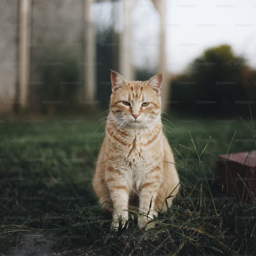

In [10]:
editing_data = image_data[4]
path, source_caption, target_caption = (
    editing_data["path"],
    editing_data["source_caption"],
    editing_data["target_caption"],
)
print(source_caption)
print(target_caption)
images = load_image(path)
images.resize((256, 256))

In [11]:
seed = 1234
generator = torch.Generator(device).manual_seed(seed)
result = pipe(
    img=images,
    prompt=source_caption,
    trg_prompt=target_caption,
    num_inference_steps=200,
    generator=generator,
    n_patches=256,
    patch_size=[1, 2],
)

  0%|          | 0/200 [00:00<?, ?it/s]

/data1/junchao/miniconda3/envs/tian/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:569: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


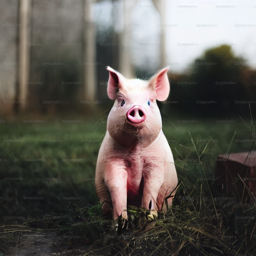

In [13]:
result.resize((256, 256))